In [30]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import logging as log
from enum import Enum
from os.path import join, exists, isfile, isdir, abspath, dirname, basename, realpath
from os import makedirs, listdir, pardir, getcwd
from dataclasses import dataclass, field
from typing import Union

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Helpful classes

In [31]:
@dataclass(frozen=False, order=False)
class CentralityAlgorithm:
    """
    A data-class to store centrality measures arguments and other options
    """
    name: str = field(default="")
    func: object = field(default=print)
    args: dict = field(default_factory=dict)
    options: dict = field(default_factory=dict)

@dataclass(frozen=False, order=False)
class CentralityAlgorithmOutput:
    """
    A data-class to store centrality measures results
    """
    name: str = field(default="")
    result: dict = field(default_factory=dict)
    options: dict = field(default_factory=dict)

class GRAPH_TYPE(str, Enum):
    BOTH = "both"
    DIRECTED = "directed"
    def __str__(self) -> str:
        return self.value

##### Helpful functions

In [32]:
def undirected_to_directed(graph: nx.Graph) -> nx.DiGraph:
    """
    Converts an undirected graph to a directed graph
    """
    di_graph = nx.DiGraph()
    di_graph.add_edges_from(graph.edges())
    return di_graph

def get_graph(graph: nx.Graph, graph_type: str) -> Union[nx.Graph, nx.DiGraph]:
    """
    Returns the graph based on the graph type
    """
    if graph_type == str(GRAPH_TYPE.DIRECTED):
        return undirected_to_directed(graph)
    elif graph_type == str(GRAPH_TYPE.BOTH):
        return graph
    else:
        print_error(f"Unknown graph type: {graph_type}")
        return graph

def convert_to_normal(snake_case: str) -> str:
    """
    Converts a snake case string to a normal title string

    Input:  "in_degree_centrality"
    Output: "In Degree Centrality"
    """
    components = snake_case.split('_')
    return " ".join(x.title() for x in components)

def print_log(text: str):
    """
    Prints the log
    """
    print(f"[ log ]: {text}")
    # log.info(f"[ log ]: {text}")

def print_error(text: str):
    """
    Prints the error
    """
    print(f"[ error ]: {text}")
    # log.warn(f"[ error ]: {text}")

#### Let's pick centrality algorithms (and the configurations)

In [33]:
algorithms_to_run = []
algorithms_to_run.append(CentralityAlgorithm("degree_centrality", nx.degree_centrality, {}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("in_degree_centrality", nx.in_degree_centrality, {}, {"direction":"directed"}))
algorithms_to_run.append(CentralityAlgorithm("out_degree_centrality", nx.out_degree_centrality, {}, {"direction":"directed"}))
algorithms_to_run.append(CentralityAlgorithm("eigenvector_centrality", nx.eigenvector_centrality, {"max_iter":100,"tol":1.0e-6,"weight":"weight"}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("katz_centrality", nx.katz_centrality, {"alpha":0.1,"beta":1.0,"max_iter":1000,"tol":1.0e-6,"normalized":True,"weight":"weight"}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("pagerank", nx.pagerank, {"alpha":0.85,"max_iter":100,"tol":1.0e-6,"weight":"weight"}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("voterank", nx.voterank, {"number_of_nodes":10}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("closeness_centrality", nx.closeness_centrality, {"distance":"weight"}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("harmonic_centrality", nx.harmonic_centrality, {"distance":"weight"}, {"direction":"both"}))
algorithms_to_run.append(CentralityAlgorithm("betweenness_centrality", nx.betweenness_centrality, {"k":None,"seed":7,"normalized":True,"weight":"weight"}, {"direction":"both"}))

#### Get data

In [34]:
parent_dir = abspath(join(join(getcwd(), pardir), pardir))
data_dir = join(parent_dir, 'data')

In [164]:
# graph = nx.read_edgelist(join(data_dir, "DM-HT.txt"), nodetype=str, data=(("weight", float),))
graph = nx.read_edgelist(join(data_dir, "DM-HT_small.txt"), nodetype=str, data=(("weight", float),))
di_graph = undirected_to_directed(graph)
print(f"{graph}")

Graph with 27 nodes and 21 edges


In [165]:
largest_cc = max(nx.connected_components(graph), key=len)
largest_cc

{'4R79.2', 'F33A8.4', 'K08E4.1', 'Y37E3.9', 'Y59A8B.1'}

In [172]:
list(graph.adj['Y37E3.9'])

['4R79.2']

In [168]:
for x in nx.connected_components(graph):
    print(x)

{'4R79.2', 'F33A8.4', 'K08E4.1', 'Y59A8B.1', 'Y37E3.9'}
{'AC3.2', 'C55A6.10'}
{'F55F8.5', 'AC3.8', 'AC3.7', 'C36B7.6', 'R166.2'}
{'AC7.2', 'F59F5.6'}
{'Y74C9A.3', 'K08H2.6', 'B0024.11', 'K01G5.2'}
{'M142.1', 'B0024.13'}
{'T16H12.5', 'D2021.2', 'B0024.14'}
{'B0024.9', 'T27A10.3', 'ZK370.2', 'T27E9.3'}


In [159]:
# import itertools
# largest_cc = set(itertools.islice(largest_cc, 5))
# largest_cc

In [ ]:
nx.draw(nx.subgraph(graph, largest_cc))
# nx.is_connected(nx.subgraph(graph, list(largest_cc)[:25]))
# nx.is_connected(nx.subgraph(graph, largest_cc))

In [192]:
def make_graph_bigger(graph: nx.Graph, sample_size: int, sorted_cc: list, verbose: bool) -> nx.Graph:
    """
    Makes the graph bigger by adding more nodes
    """
    largest_cc = sorted_cc[0]

    __total = len(largest_cc)
    __first_node = list(largest_cc)[0]

    __graph = nx.subgraph(graph, largest_cc).copy()

    for cc in sorted_cc[1:]:
        # return if adding another connected component will make the graph bigger than sample size
        if (len(__graph) + len(cc)) > sample_size: break

        # add new edge to make the graph connected
        __graph.add_edge(__first_node, list(cc)[0])
    return __graph

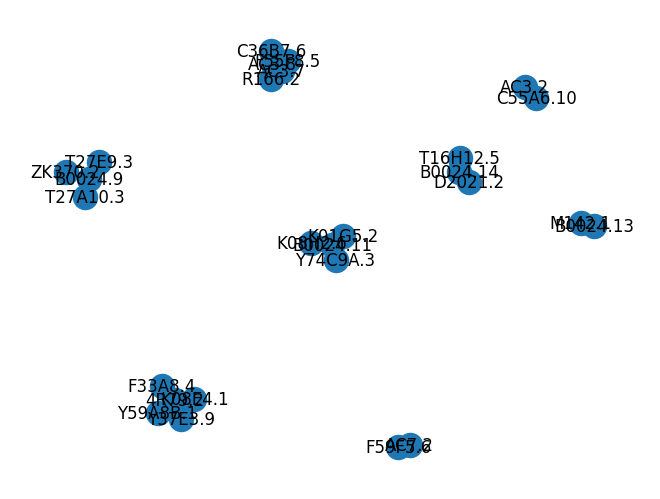

In [197]:
nx.draw(graph, with_labels=True)

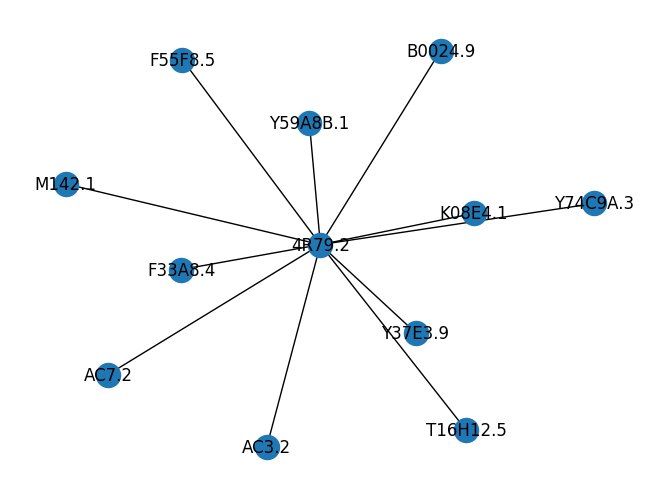

In [196]:
nx.draw(make_graph_bigger(graph, 25, sorted(nx.connected_components(graph), key=len, reverse=True), True), with_labels=True)

In [ ]:
from networkx import is_connected

def make_graph_bigger(graph: nx.Graph, sample_size: int, sorted_cc: list, verbose: bool) -> nx.Graph:
    """
    Makes the graph bigger by adding more nodes
    """
    largest_cc = sorted_cc[0]

    __total = len(largest_cc)
    __first_node = list(largest_cc)[0]

    __graph = nx.subgraph(graph, largest_cc)

    for cc in sorted_cc[1:]:
        # return if adding another connected component will make the graph bigger than sample size
        if (len(__graph) + len(cc)) > sample_size: break

        # add new edge to make the graph connected
        __graph.add_edge(__first_node, list(cc)[0])
    return __graph

def sample_graph(graph: nx.Graph, sample_size: int, verbose: bool) -> nx.Graph:
    """
    Returns a sample graph of the given size
    """



    sorted_cc = sorted(nx.connected_components(graph), key=len, reverse=True)
    largest_cc = sorted_cc[0]

    if sample_size > len(largest_cc):
        if verbose: print_error(f"Sample size {sample_size} is greater than the largest connected component size {len(largest_cc)}")
        
        if nx.is_connected(graph):
            if verbose: print_log(f"Graph is connected")
            return graph
        else:
            # make it bigger


            return graph
    else:
        # make it shorter

        
        


    
    return nx.subgraph(graph, largest_cc[:sample_size])

In [ ]:
[len(x) for x in sorted(nx.connected_components(graph), key=len, reverse=True)]

In [187]:
# sorted(nx.connected_components(graph), key=len, reverse=True)[1]
list(sorted(nx.connected_components(graph), key=len, reverse=True)[0])[0]

'4R79.2'

In [189]:
str(graph)

'Graph with 27 nodes and 21 edges'

In [173]:
largest_cc

{'4R79.2', 'F33A8.4', 'K08E4.1', 'Y37E3.9', 'Y59A8B.1'}

In [171]:
for n, v in graph.adjacency():
    print(f"{n}: {v}")

4R79.2: {'F33A8.4': {'weight': 2.0535098696773}, 'K08E4.1': {'weight': 1.71816616036671}, 'Y37E3.9': {'weight': 2.0535098696773}, 'Y59A8B.1': {'weight': 2.03824718864659}}
F33A8.4: {'4R79.2': {'weight': 2.0535098696773}}
K08E4.1: {'4R79.2': {'weight': 1.71816616036671}}
Y37E3.9: {'4R79.2': {'weight': 2.0535098696773}}
Y59A8B.1: {'4R79.2': {'weight': 2.03824718864659}}
AC3.2: {'C55A6.10': {'weight': 1.45314520221391}}
C55A6.10: {'AC3.2': {'weight': 1.45314520221391}}
AC3.7: {'C36B7.6': {'weight': 1.72056305302742}, 'F55F8.5': {'weight': 3.64469409198139}, 'R166.2': {'weight': 3.6241172604793}}
C36B7.6: {'AC3.7': {'weight': 1.72056305302742}, 'AC3.8': {'weight': 2.95263550099055}}
F55F8.5: {'AC3.7': {'weight': 3.64469409198139}, 'AC3.8': {'weight': 3.64590831935301}}
R166.2: {'AC3.7': {'weight': 3.6241172604793}, 'AC3.8': {'weight': 3.64445039181658}}
AC3.8: {'C36B7.6': {'weight': 2.95263550099055}, 'F55F8.5': {'weight': 3.64590831935301}, 'R166.2': {'weight': 3.64445039181658}}
AC7.2: {

In [117]:
# __graph = K5
# node = list(__graph.nodes())[1]
# print(f"Node: {node}\nNeighbors: {list(nx.all_neighbors(__graph, node))}")
# nx.draw(nx.subgraph(__graph, nx.all_neighbors(__graph, node)), with_labels=True)

In [66]:
n = 30



NetworkXError: G is not a line graph(partition cell not a complete subgraph)

#### Compute all algorithms on our data

In [36]:
def compute_algorithms(graph: nx.Graph, algorithms: list, verbose: bool) -> list:
    """
    Computes the centrality measures for the given graph
    """
    centrality_measures = list()
    for i, algorithm in enumerate(algorithms):
        algorithm_name = convert_to_normal(algorithm.name)
        graph_direction = algorithm.options["direction"]

        if verbose:
            print_log(f"Running '{algorithm_name}' ({i+1}/{len(algorithms)})")
            print_log(f"Option: '{algorithm.options}'")

        # if graph is not directed or undirected, then skip -> invalid direction option
        if graph_direction != str(GRAPH_TYPE.BOTH) and graph_direction != str(GRAPH_TYPE.DIRECTED):
            if verbose: print_error(f"Invalid direction: '{graph_direction}'")
            continue

        __graph = get_graph(graph=graph, graph_type=graph_direction)
        __centrality = algorithm.func(__graph, **algorithm.args)

        # return the degree as the weight
        if isinstance(__centrality, list):
            __centrality = {node: __graph.degree(node) for node in __centrality}

        centrality_measures.append(CentralityAlgorithmOutput(algorithm.name, __centrality, algorithm.options))

        if verbose:
            print_log(f"Result: '{__centrality}'")
            print_log(f"="*50)
    return centrality_measures

In [37]:
centrality_measures = compute_algorithms(graph=graph, algorithms=algorithms_to_run, verbose=False)

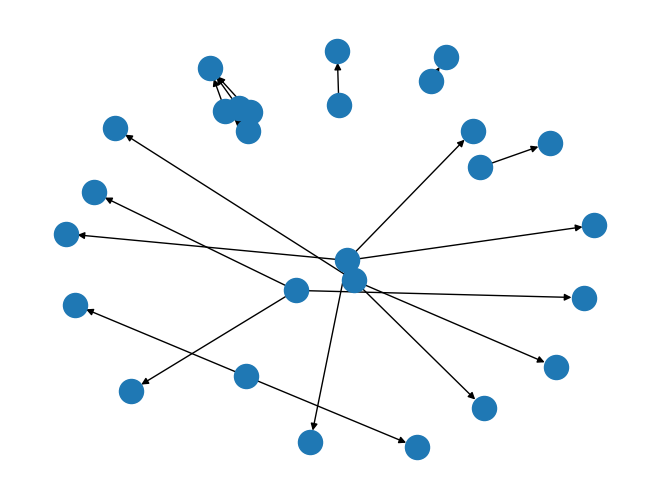

In [41]:
nx.draw(di_graph)

In [ ]:
# pos=nx.planar_layout(graph_fly)
nx.draw(graph_fly)

In [ ]:
#draw the sample subgraph in matplotlib
pos=nx.planar_layout(graph_fly_sampleDraw)
labels = nx.get_edge_attributes(graph_fly_sampleDraw,'weight')
nx.draw(graph_fly_sampleDraw,with_labels=True,pos=pos)
nx.draw_networkx_edge_labels(graph_fly_sampleDraw,pos=pos,edge_labels=labels,verticalalignment="bottom",font_size=10)
ax = plt.gca()
ax.margins(0.1)
plt.axis("on")
plt.title("Subgraph of Flies' Protein-protien Interactions")
plt.show()